# ERCC Transcript normalisation

In [1]:
# Import necessary libraries
import os
import sys
import pandas as pd
import numpy as np
from scipy import constants
import seaborn as sns
import matplotlib.pyplot as plt

# Add 'scripts' and its subdirectories to Python's module search path to allow importing custom modules. 
sys.path.insert(1, 'scripts')

from utils import merge_kallisto

In [2]:
# Merge kallisto counts into one dataframe
merge_kallisto('../data/ERCC92/kallisto', '../data/ERCC92')

In [3]:
# Load ERCC counts
counts_ERCC = pd.read_csv('../data/ERCC92/count.csv')
tpm_ERCC = pd.read_csv('../data/ERCC92/tpm.csv')

# Load ERCC metadata
meta_ERCC = pd.read_table('../data/ERCC92/ERCC_Controls_Analysis.txt')

# Load lab metadata
lab_info = pd.read_csv('../data/ERCC92/sampling_RNA_Spike_LibPrep.csv', sep=';', decimal=',')

# Load sample metadata
sample = pd.read_csv('../data/samples.csv', sep=';', decimal=',')

In [4]:
# Extract the squared coefficient of variance from each row, ignoring the first column containing the ERCC ID
coeff_var = (np.std(counts_ERCC.iloc[:, 1:], axis=1) / np.mean(counts_ERCC.iloc[:, 1:], axis=1)) ** 2
# Extract the mean expression from each row
mean_expression = np.mean(counts_ERCC.iloc[:, 1:], axis=1)

In [5]:
# Combine both values in a dataframe
df = pd.DataFrame()
df['CV2'] = coeff_var
df['CV'] = np.sqrt(coeff_var)
df['mean_expression'] = mean_expression
df['log_mean_expression'] = np.log10(mean_expression + 1)

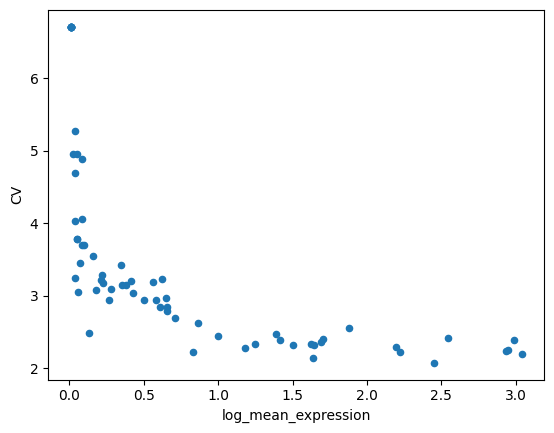

In [6]:
df.plot('log_mean_expression', 'CV', kind='scatter', alpha=1);

In [7]:
# Melt the TPM dataframe to long format
counts_ERCC = counts_ERCC.melt(id_vars='target_id', var_name='sample_name', value_name='count')
# Melt the count dataframe to long format
tpm_ERCC = tpm_ERCC.melt(id_vars='target_id', var_name='sample_name', value_name='TPM')

# Merge both
counts_ERCC = counts_ERCC.merge(tpm_ERCC, left_on=['sample_name', 'target_id'], right_on=['sample_name', 'target_id'])

# Add metadata
counts_ERCC = counts_ERCC.merge(meta_ERCC, left_on='target_id', right_on='ERCC_ID')
# Drop irrelevant columns
counts_ERCC = counts_ERCC.drop(columns=['target_id', 'Re-sort ID', 'subgroup', 'concentration_Mix_2', 'expected_fold_change ratio', 'log2_Mix_1_Mix_2'])
# Add how much spike mix was added
counts_ERCC = counts_ERCC.merge(lab_info, left_on='sample_name', right_on='sample_name')

counts_ERCC.head()

,sample_name,count,TPM,ERCC_ID,concentration_Mix_1,SW_filtered,eluate_volume_mL,rna_extraction_vol_mL,RNA_conc_ng_µl,RNA_eluate_µL,µl_RNA_used _for_start_LP,pre_dil,ng_RNA_used_for_start_LP,µl_ERCC_spike,ERCC_dilution,sequenced_at,standards_added_by,standards_added_before
0,51_4,121,117656.00,ERCC-00002,15000.000000,50,7.0,3.0,9.321,50,21.46,1,200.0,4.0,0.001,Macrogen,Macrogen,library_preparation
1,51_4,0,0.00,ERCC-00003,937.500000,50,7.0,3.0,9.321,50,21.46,1,200.0,4.0,0.001,Macrogen,Macrogen,library_preparation
2,51_4,31,81532.50,ERCC-00004,7500.000000,50,7.0,3.0,9.321,50,21.46,1,200.0,4.0,0.001,Macrogen,Macrogen,library_preparation
3,51_4,8,8550.24,ERCC-00009,937.500000,50,7.0,3.0,9.321,50,21.46,1,200.0,4.0,0.001,Macrogen,Macrogen,library_preparation
4,51_4,0,0.00,ERCC-00012,0.114441,50,7.0,3.0,9.321,50,21.46,1,200.0,4.0,0.001,Macrogen,Macrogen,library_preparation


In [8]:
# Add transformed concentration column to reflect the amount of moles spike added which also incorporates wet lab dilution
counts_ERCC['attomoles_in_total_RNA'] = counts_ERCC['concentration_Mix_1'] * (counts_ERCC['µl_ERCC_spike'] * counts_ERCC['ERCC_dilution'])

# Calculate absolute number of molecules per sample using Avogadro's number, but first we need to converse attomoles to moles (atto = 10^-18) 
counts_ERCC['ERCC_copies'] = counts_ERCC['attomoles_in_total_RNA'] * 10**-18 *constants.Avogadro

## Lower Limit of Detection
Let's identify the smallest amount of ERCC copies that result in a detectable TPM signal

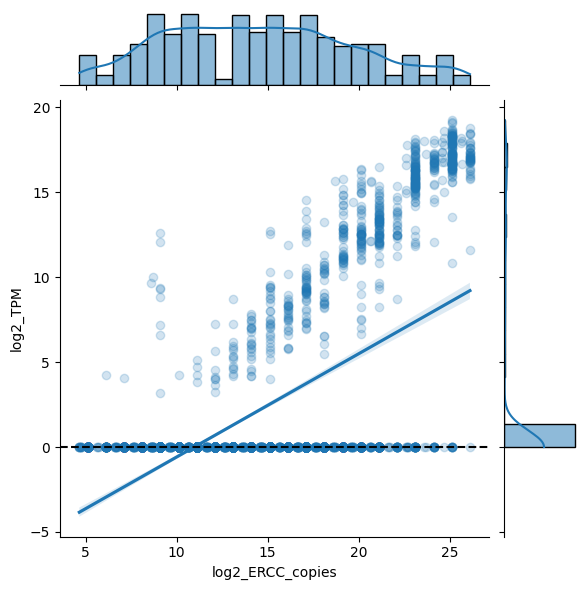

In [9]:
plotdata = counts_ERCC[['ERCC_copies', 'TPM']].copy()
# Add a pseudocount to avoid trying to get log 0
plotdata['ERCC_copies'] = np.log2(plotdata['ERCC_copies'] +1)
plotdata['TPM'] = np.log2(plotdata['TPM'] + 1)
plotdata.columns = ['log2_ERCC_copies', 'log2_TPM']

# Plot the data
plot = sns.jointplot(data=plotdata,
            x='log2_ERCC_copies',
            y='log2_TPM',
            kind='reg',
            joint_kws = {'scatter_kws':dict(alpha=0.2)}
)

# Add horizontal line at 0
plot.ax_joint.axhline(0, color='black', linestyle='--')

# Save the plot as a svg
#plot.savefig('../../figures/assembly/ERCC92_TPM_vs_copies.svg')

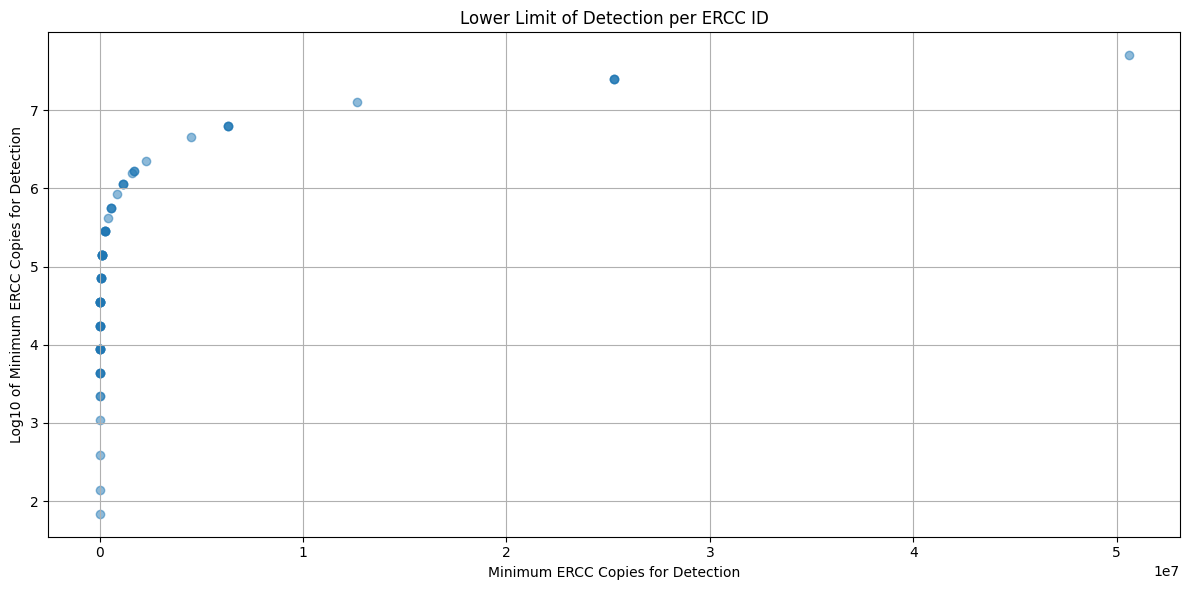

The ovarall minimum number of ERCC copies required for detection is approx. 68.91793289438992 copies.


In [10]:
# Calculate the minimum detectable TPM for each ERCC ID
detectable_tpm = counts_ERCC[counts_ERCC['TPM'] > 0]  # Filter out samples with no detected TPM
min_detectable_tpm_per_ercc = detectable_tpm.groupby('ERCC_ID')['ERCC_copies'].min().reset_index()

# Plot the relationship between ERCC copies and the minimum detectable TPM
plt.figure(figsize=(12, 6))
plt.scatter(min_detectable_tpm_per_ercc['ERCC_copies'], np.log10(min_detectable_tpm_per_ercc['ERCC_copies']), alpha=0.5)
plt.xlabel('Minimum ERCC Copies for Detection')
plt.ylabel('Log10 of Minimum ERCC Copies for Detection')
plt.title('Lower Limit of Detection per ERCC ID')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

# Also, report the overall minimum ERCC copies detected
overall_min_ercc_copies = min_detectable_tpm_per_ercc['ERCC_copies'].min()
print('The ovarall minimum number of ERCC copies required for detection is approx. {} copies.'.format(overall_min_ercc_copies))

## ERCC Recovery per campaign
Let's see if there's differences between the two 24H cycli.

In [11]:
def plot_ercc_heatmap(df, values='count'):
    """
    Generates a heatmap displaying ERCC counts for all ERCCs across all samples.
    
    Parameters:
    - df: A pandas DataFrame containing the dataset with columns for 'sample_name', 'ERCC_ID', and 'TPM' or 'counts'.
    
    The DataFrame is expected to have a row for each ERCC-sample combination.
    """
    # Pivot the DataFrame to create a matrix of ERCC counts with samples as columns and ERCC IDs as rows
    ercc_matrix = df.pivot(index='ERCC_ID', columns='sample_name', values=values)
    
    # Plot the heatmap
    plt.figure(figsize=(20, 10))
    sns.heatmap(ercc_matrix, cmap='viridis', linewidths=0.1, linecolor='gray', cbar_kws={'label': values})
    plt.title('Heatmap of ERCC Counts Across All Samples')
    plt.xlabel('Sample Name')
    plt.ylabel('ERCC ID')
    plt.xticks(rotation=90)  # Rotate sample names for better readability
    plt.tight_layout()
    
    # Show the plot
    plt.show()

In [12]:
counts_ERCC.head()

,sample_name,count,TPM,ERCC_ID,concentration_Mix_1,SW_filtered,eluate_volume_mL,rna_extraction_vol_mL,RNA_conc_ng_µl,RNA_eluate_µL,µl_RNA_used _for_start_LP,pre_dil,ng_RNA_used_for_start_LP,µl_ERCC_spike,ERCC_dilution,sequenced_at,standards_added_by,standards_added_before,attomoles_in_total_RNA,ERCC_copies
0,51_4,121,117656.00,ERCC-00002,15000.000000,50,7.0,3.0,9.321,50,21.46,1,200.0,4.0,0.001,Macrogen,Macrogen,library_preparation,60.000000,3.613284e+07
1,51_4,0,0.00,ERCC-00003,937.500000,50,7.0,3.0,9.321,50,21.46,1,200.0,4.0,0.001,Macrogen,Macrogen,library_preparation,3.750000,2.258303e+06
2,51_4,31,81532.50,ERCC-00004,7500.000000,50,7.0,3.0,9.321,50,21.46,1,200.0,4.0,0.001,Macrogen,Macrogen,library_preparation,30.000000,1.806642e+07
3,51_4,8,8550.24,ERCC-00009,937.500000,50,7.0,3.0,9.321,50,21.46,1,200.0,4.0,0.001,Macrogen,Macrogen,library_preparation,3.750000,2.258303e+06
4,51_4,0,0.00,ERCC-00012,0.114441,50,7.0,3.0,9.321,50,21.46,1,200.0,4.0,0.001,Macrogen,Macrogen,library_preparation,0.000458,2.756717e+02


In [13]:
counts_ERCC = counts_ERCC.merge(sample, on='sample_name')

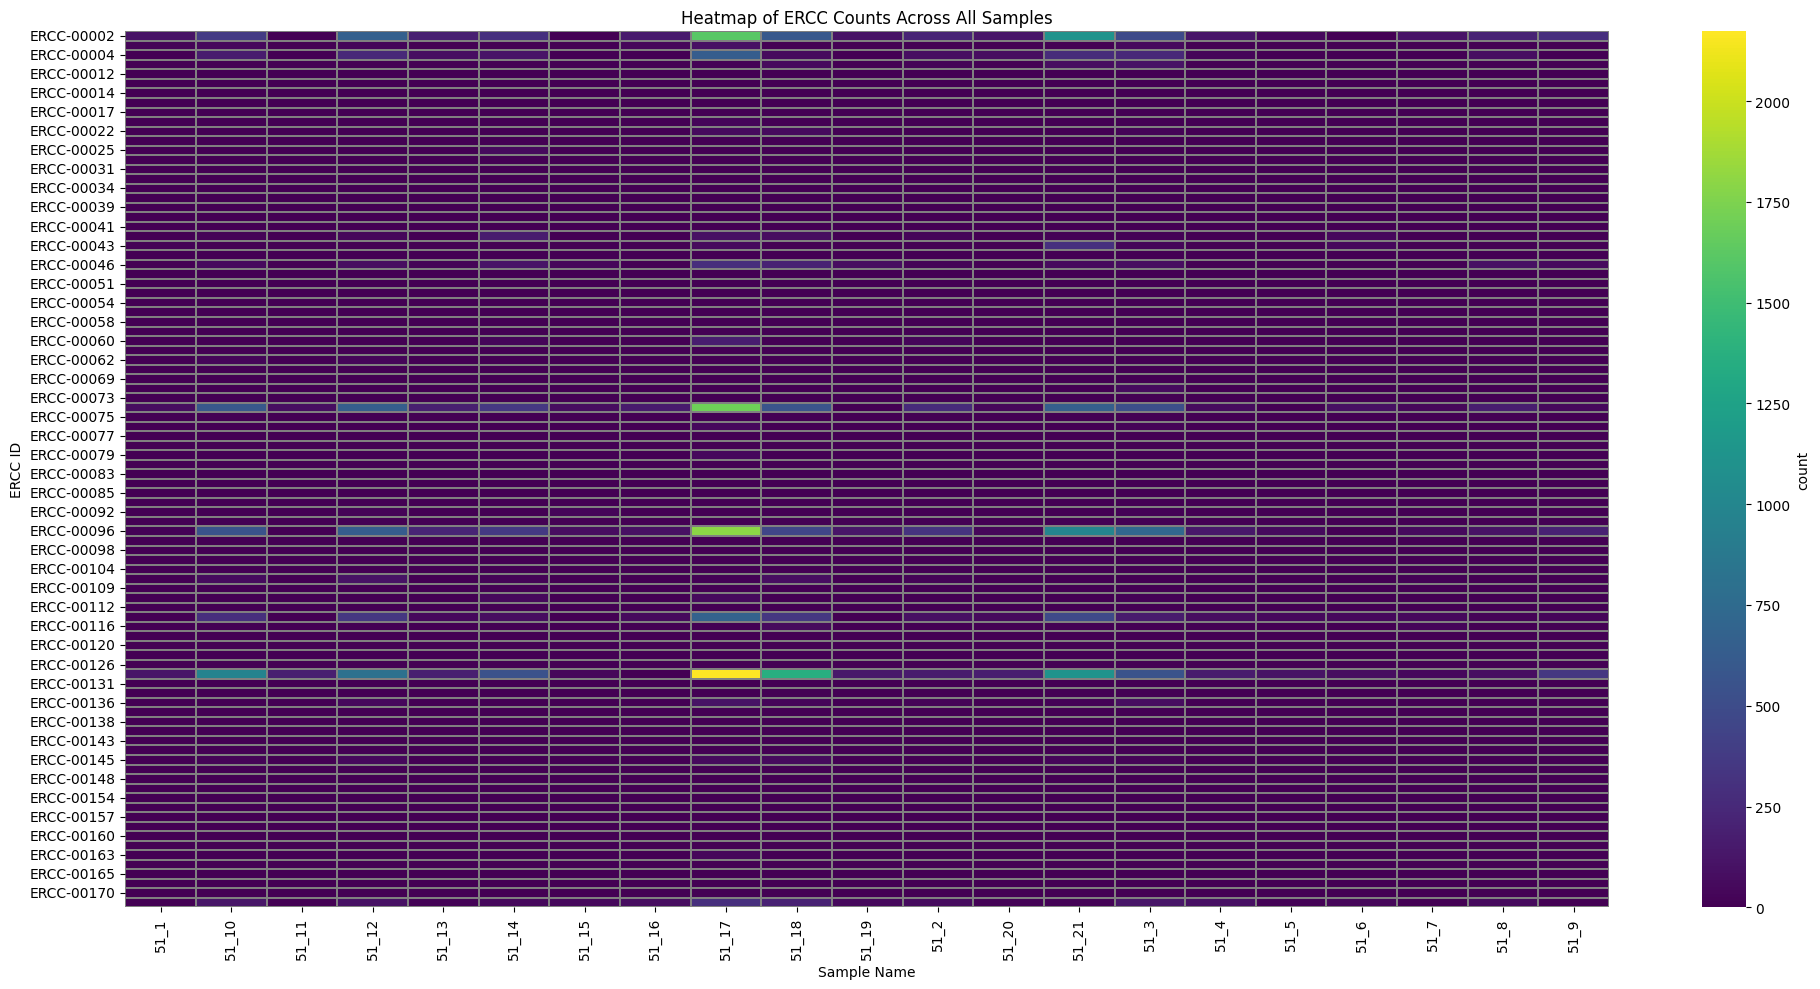

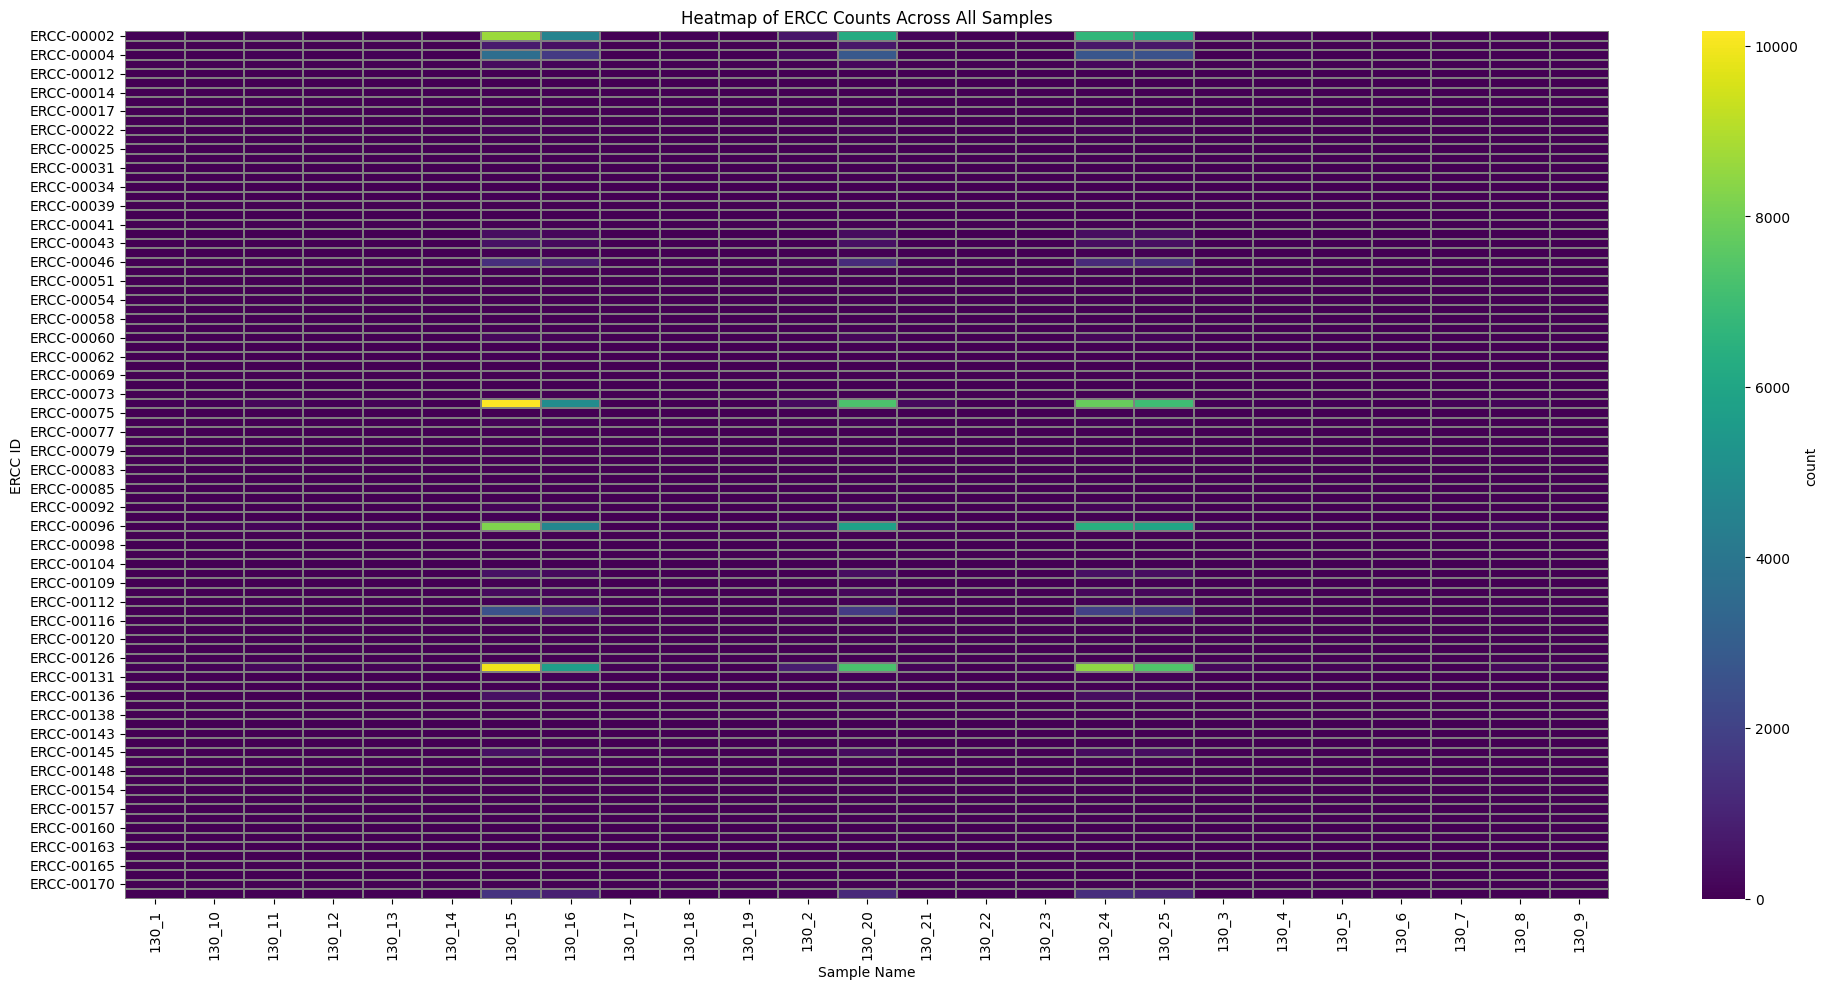

In [14]:
for station in [51, 130]:
    plot_df = counts_ERCC[counts_ERCC['station'] == station]
    plot_ercc_heatmap(plot_df)

## Transcripts per L
In this section we try and implement transcript quantification using the added mRNA standards.
We will use a modified version of the read normalisation protocol described in [this paper](https://www.frontiersin.org/articles/10.3389/fmars.2022.867007/full). 

We'll use this normalisation approach:

$$Copies_i\:L^{-1} = reads_{i,j} *\frac{spike\:copies_{j}}{spike\:reads_{j}} * \frac{1}{volume\:filtered_{j} * \frac{mL\:used\:for\:RNA\:extraction_{j}}{elution\:volume_{j}}} * \frac{1}{ \frac{RNA\:used\:for\:LP}{total\:extracted\:RNA}}$$

- Reads<sub>i,j</sub> =  TPM counts for read i in sample j. These already account for transcript length bias.
- Spike copies<sub>j</sub> = The number of ERCC copies that were added to sample j
- Spike reads<sub>j</sub> = The number of TPM read counts associated with the mRNA standards
- Volume filtered<sub>j</sub> = The total L of seawater filtered for sample j
- mL used for RNA extraction<sub>j</sub> = The amount of eluate used for RNA extraction. This is variable due to variations in biomass to keep the extraction protocol as optimal as possible.
- Elution volume<sub>j</sub> = The residue on the inox sieve after the seawater filtration is re-eluted to be flash frozen. The re-elution volume also varied with variations in biomass.
- RNA used for LP<sub>j</sub> = The amount of RNA used for library preparation
- Total extracted RNA<sub>j</sub> = The total amount of RNA extracted from the sample, as measured by the Qubit RNA HS assay at Nucleomics. This is the product of the RNA concentration, the total volume of eluate used for RNA extraction, and a possible dilution factor.

We will calculate normalised reads using a step-by-step approach. First, we'll calculate the ERCC normalisation factor. Then, we will calculate the dilution factor. Third, we will calculate the RNA extraction factor.
Then, we will transform the salmon TPM reads accordingly and generate normalised reads per L of seawater.

In [15]:
mean_TPM = counts_ERCC['TPM'].mean()
mean_copies = counts_ERCC['ERCC_copies'].mean()
print(f'The average TPM count: {mean_TPM}')
print(f'The average number of ERCC copies added to a sample: {mean_copies}')
median_TPM = counts_ERCC['TPM'].median()
median_copies = counts_ERCC['ERCC_copies'].median()
print(f'The median TPM count: {median_TPM}')
print(f'The median number of transcript copies added to a sample: {median_copies}')
print(f'On average, 1 TPM equals {mean_copies/mean_TPM} copies')

The average TPM count: 10869.566279215502
The average number of ERCC copies added to a sample: 2644954.759241316
The median TPM count: 0.0
The median number of transcript copies added to a sample: 17642.9905078125
On average, 1 TPM equals 243.33581407925436 copies


### ERCC normalisation factor

In [16]:
# First remove the rows with TPM counts equalling zero
counts_ERCC = counts_ERCC[counts_ERCC['TPM'] > 0]
counts_ERCC['ERCC_norm_factor'] = counts_ERCC['ERCC_copies'] / counts_ERCC['TPM']

[None]

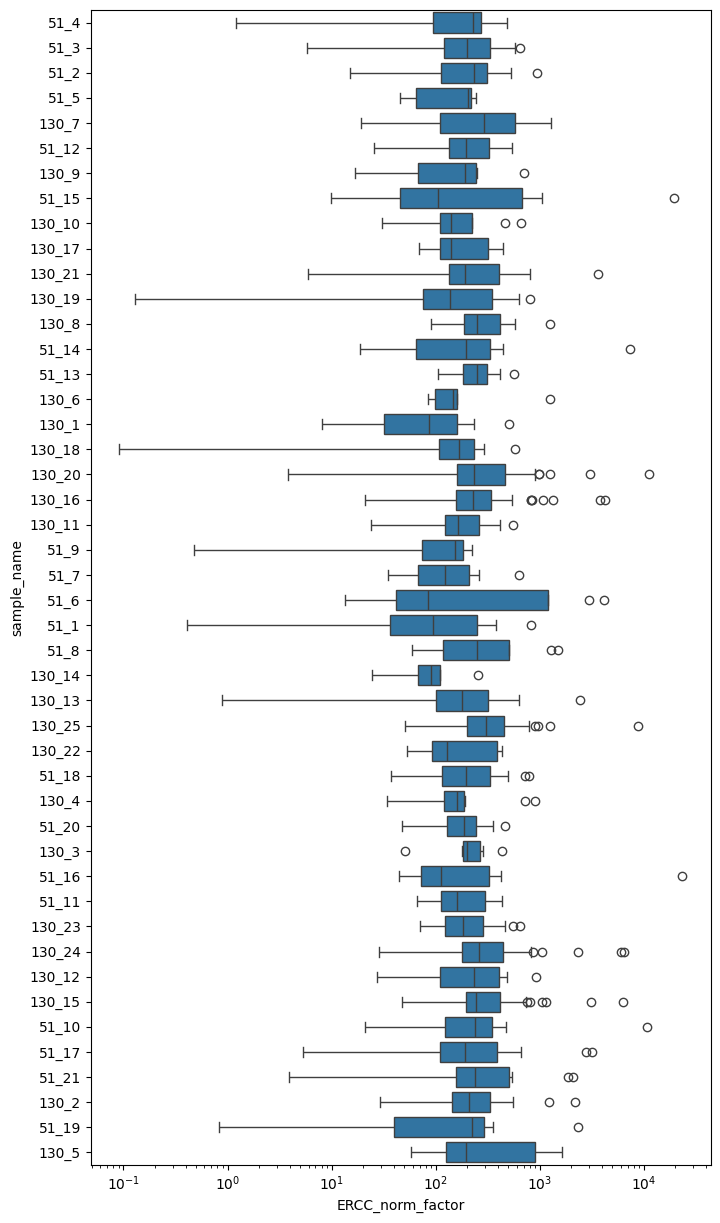

In [17]:
# Let's check per sample the recovery of all ERCC
plt.figure(figsize=(8,15))
ax =sns.boxplot(x='ERCC_norm_factor', y='sample_name', data=counts_ERCC)
ax.set(xscale='log')

In [18]:
# Group all ERCCs together per sample and take the average recovery
ERCC_normalisation = counts_ERCC[['sample_name', 'ERCC_norm_factor']].groupby('sample_name').mean().reset_index()
ERCC_normalisation.head()

,sample_name,ERCC_norm_factor
0,130_1,140.921039
1,130_10,227.191739
2,130_11,202.837639
3,130_12,289.985017
4,130_13,362.913425


### Dilution factor
Here, we'll calculate the second term of the equation:

$$   \frac{1}{volume\:filtered_{j} * \frac{mL\:used\:for\:RNA\:extraction_{j}}{elution\:volume_{j}}}$$

In [19]:
lab_info = lab_info.dropna(how = 'all')
lab_info = lab_info.fillna(1)
lab_info.head()

,sample_name,SW_filtered,eluate_volume_mL,rna_extraction_vol_mL,RNA_conc_ng_µl,RNA_eluate_µL,µl_RNA_used _for_start_LP,pre_dil,ng_RNA_used_for_start_LP,µl_ERCC_spike,ERCC_dilution,sequenced_at,standards_added_by,standards_added_before
0,7_20_ZG02,50,18.0,2.0,16.84,50,11.88,1,200.0,4.0,0.001,Nucleomics,Nucleomics,library_preparation
1,7_20_330,50,18.0,6.0,354.00,50,1.13,2,200.0,4.0,0.001,Nucleomics,Nucleomics,library_preparation
2,7_20_700,50,18.0,6.0,652.00,50,0.61,2,200.0,4.0,0.001,Nucleomics,Nucleomics,library_preparation
3,8_20_ZG02,50,34.0,7.0,27.37,50,7.31,1,200.0,4.0,0.001,Nucleomics,Nucleomics,library_preparation
4,8_20_330,50,36.0,9.0,116.50,50,1.72,1,200.0,4.0,0.001,Nucleomics,Nucleomics,library_preparation


In [20]:
# Merge both first to ensure correct sample order
ERCC_normalisation = ERCC_normalisation.merge(lab_info[['sample_name', 'SW_filtered', 'rna_extraction_vol_mL','eluate_volume_mL', 'RNA_conc_ng_µl', 'RNA_eluate_µL', 'ng_RNA_used_for_start_LP']], left_on='sample_name', right_on='sample_name')

ERCC_normalisation['dilution_norm_factor'] = (1 / (ERCC_normalisation['SW_filtered'] * (ERCC_normalisation['rna_extraction_vol_mL'] / ERCC_normalisation['eluate_volume_mL'])))

### RNA extraction factor
Here, we'll calculate the third term of the equation:

$$ \frac{RNA\:used\:for\:LP}{total\:extracted\:RNA}$$

Which is equivalent to:

$$ \frac{RNA\:used\:for\:LP}{RNA\:concentration * RNA\:eluate\:volume}$$

In [21]:
ERCC_normalisation['RNA_extraction_factor'] = ERCC_normalisation['ng_RNA_used_for_start_LP'] / (ERCC_normalisation['RNA_conc_ng_µl'] * ERCC_normalisation['RNA_eluate_µL'])

In [22]:
ERCC_normalisation['norm_factor'] = ERCC_normalisation['ERCC_norm_factor'] * ERCC_normalisation['dilution_norm_factor'] * (1 / ERCC_normalisation['RNA_extraction_factor'])
ERCC_normalisation = ERCC_normalisation.drop(columns=['SW_filtered', 'rna_extraction_vol_mL','eluate_volume_mL', 'eluate_volume_mL', 'RNA_conc_ng_µl', 'RNA_eluate_µL', 'ng_RNA_used_for_start_LP'])
ERCC_normalisation.head()

,sample_name,ERCC_norm_factor,dilution_norm_factor,RNA_extraction_factor,norm_factor
0,130_1,140.921039,0.066667,0.593648,15.825433
1,130_10,227.191739,0.020000,0.024973,181.953320
2,130_11,202.837639,0.050000,0.158592,63.949637
3,130_12,289.985017,0.047500,0.216392,63.654430
4,130_13,362.913425,0.042500,0.060758,253.856807


<Axes: xlabel='norm_factor', ylabel='sample_name'>

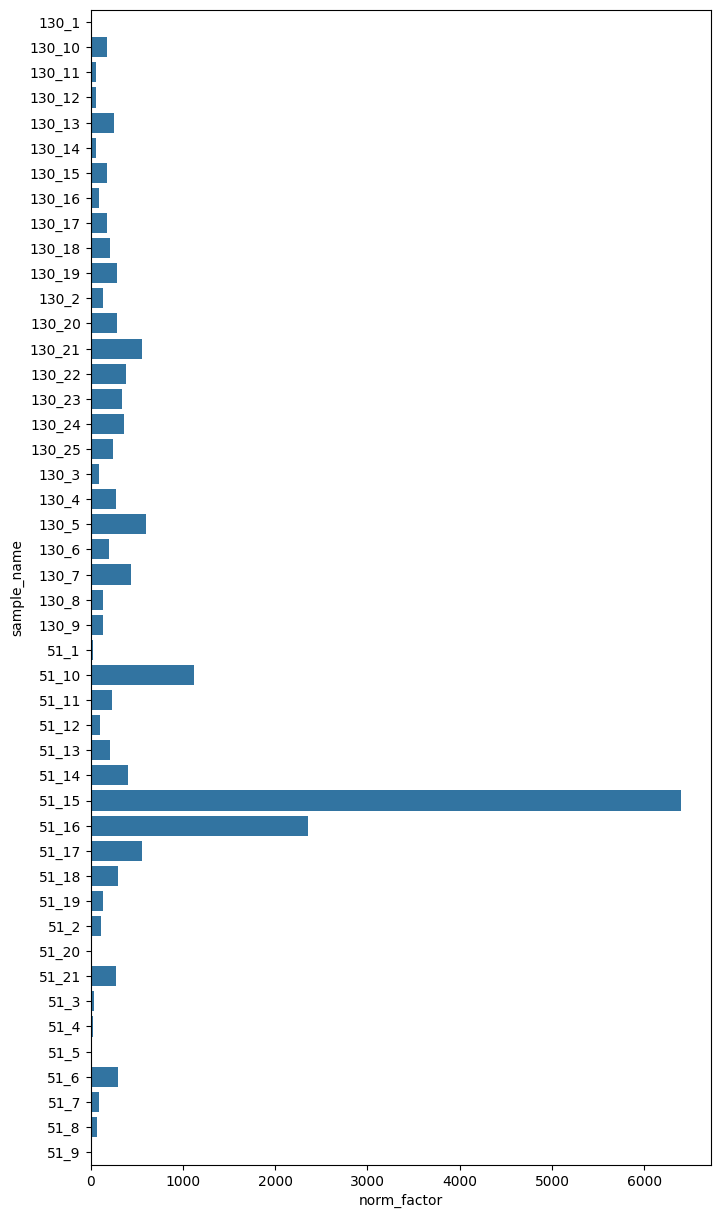

In [23]:
plt.figure(figsize=(8,15))
sns.barplot(x='norm_factor', y='sample_name', data=ERCC_normalisation)

In [24]:
# Save the TPL normalization factors
ERCC_normalisation[['sample_name', 'ERCC_norm_factor']].to_csv('../data/ERCC92/ERCC_normalisation.csv', index=False)

### Calculate transcripts per L
Finally, we'll calculate the normalised reads per L of seawater.

/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_11123/4279786474.py:17: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  transcripts_per_L = gene_expression.pivot_table(index='target_id', columns='sample_ID', values='transcripts_per_L', aggfunc=np.sum)
/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_11123/4279786474.py:17: FutureWarning: The provided callable <function sum at 0x105fcd940> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  transcripts_per_L = gene_expression.pivot_table(index='target_id', columns='sample_ID', values='transcripts_per_L', aggfunc=np.sum)


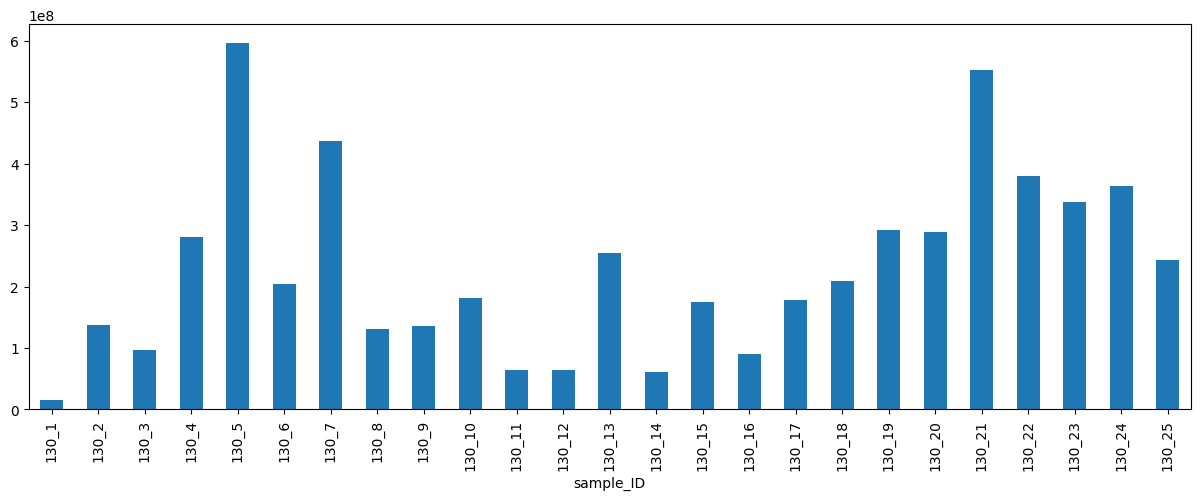

In [25]:
# Load the data
gene_expression = pd.read_csv('../data/quantification/130/130_tpm.csv')

# Melt the data to long format
gene_expression = gene_expression.melt(id_vars=['target_id'], var_name='sample_ID', value_name='TPM')
# Convert to categorical data type for efficiency
gene_expression['sample_ID'] = gene_expression['sample_ID'].astype('category')
gene_expression['target_id'] = gene_expression['target_id'].astype('category')

# Merge with normalization factors
gene_expression = gene_expression.merge(ERCC_normalisation[['sample_name', 'norm_factor']], left_on='sample_ID', right_on='sample_name', how='outer')

# Calculate transcripts per L and adjust data types to save memory
gene_expression['transcripts_per_L'] = gene_expression['TPM'].astype(np.float32) * gene_expression['norm_factor'].astype(np.float32)

# Transform data to wide format
transcripts_per_L = gene_expression.pivot_table(index='target_id', columns='sample_ID', values='transcripts_per_L', aggfunc=np.sum)

# Free up memory by deleting the original large DataFrame if it's no longer needed
del gene_expression

# Sort columns by their numeric part
sorted_columns = sorted(transcripts_per_L.columns, key=lambda x: int(x.split('_')[1]))

# Reorder the dataframe based on the sorted columns
transcripts_per_L = transcripts_per_L[sorted_columns]

# Export the data
transcripts_per_L.to_csv('../data/quantification/130/130_tpl.csv')

# Plot the data
transcripts_per_L.sum(axis=0).plot(kind='bar', figsize=(15, 5))

# Get the TPL sum for each sample
tpl_sum_130 = transcripts_per_L.sum(axis=0)

/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_11123/4169209320.py:17: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  transcripts_per_L = gene_expression.pivot_table(index='target_id', columns='sample_ID', values='transcripts_per_L', aggfunc=np.sum)
/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_11123/4169209320.py:17: FutureWarning: The provided callable <function sum at 0x105fcd940> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  transcripts_per_L = gene_expression.pivot_table(index='target_id', columns='sample_ID', values='transcripts_per_L', aggfunc=np.sum)


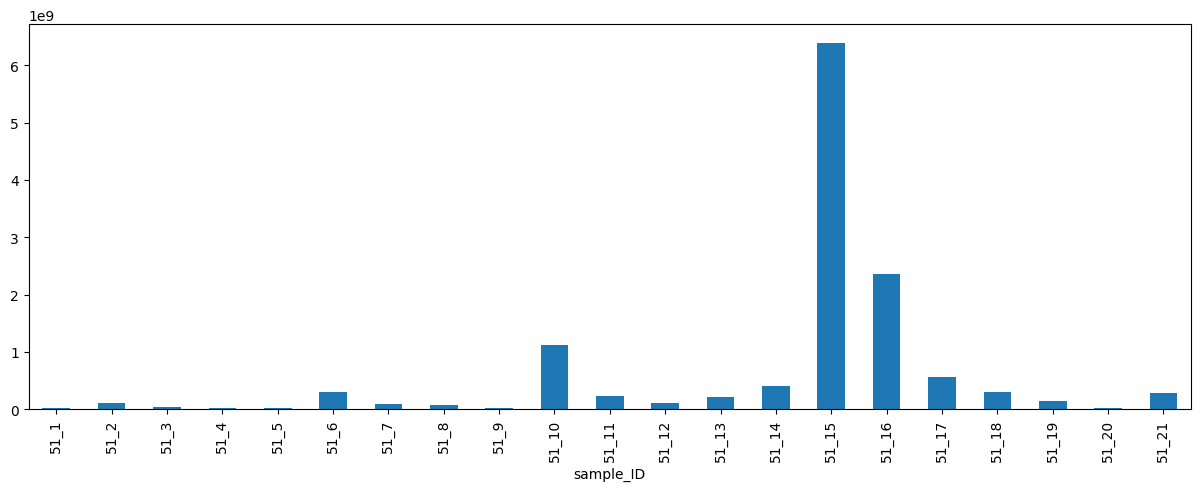

In [26]:
# Load the data
gene_expression = pd.read_csv('../data/quantification/51/51_tpm.csv')

# Melt the data to long format
gene_expression = gene_expression.melt(id_vars=['target_id'], var_name='sample_ID', value_name='TPM')
# Convert to categorical data type for efficiency
gene_expression['sample_ID'] = gene_expression['sample_ID'].astype('category')
gene_expression['target_id'] = gene_expression['target_id'].astype('category')

# Merge with normalization factors
gene_expression = gene_expression.merge(ERCC_normalisation[['sample_name', 'norm_factor']], left_on='sample_ID', right_on='sample_name', how='outer')

# Calculate transcripts per L and adjust data types to save memory
gene_expression['transcripts_per_L'] = gene_expression['TPM'].astype(np.float32) * gene_expression['norm_factor'].astype(np.float32)

# Transform data to wide format
transcripts_per_L = gene_expression.pivot_table(index='target_id', columns='sample_ID', values='transcripts_per_L', aggfunc=np.sum)

# Free up memory by deleting the original large DataFrame if it's no longer needed
del gene_expression

# Sort columns by their numeric part
sorted_columns = sorted(transcripts_per_L.columns, key=lambda x: int(x.split('_')[1]))

# Reorder the dataframe based on the sorted columns
transcripts_per_L = transcripts_per_L[sorted_columns]

# Export the data
transcripts_per_L.to_csv('../data/quantification/51/51_tpl.csv')

# Plot the data
transcripts_per_L.sum(axis=0).plot(kind='bar', figsize=(15, 5))

# Get the TPL sum for each sample
tpl_sum_51 = transcripts_per_L.sum(axis=0)

In [27]:
# Combine the TPL sums for both stations
tpl_sum = pd.concat([tpl_sum_51, tpl_sum_130], axis=0)

# Export the data
tpl_sum.to_csv('../data/analysis/tpl_sum.csv')